# Chicago Crime Data API Pull and Exploration

In [2]:
from util import api_util
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_util.get_socrata_app_token()

'FgSIlio2ikkxrA8YFFblYJDcc'

In [3]:
class SocrataAPIClient:
    """
    Class for making requests to Socrata Chicago API
    and parsing, updating the response object
    """

    def __init__(self, request_url):

        self.request_url = None
        self.params = self._get_app_token_params()
        self.response = None
        self.data_df = None

        # for reviewing datatypes
        self.header_fields = None
        self.header_dtypes = None

        self._get_request(request_url)

    @staticmethod
    def _get_app_token_params():
        """
        gets api token and formats the params dict for request
        :return: dict containing app token
        """
        token = api_util.get_socrata_app_token()
        return {"$$app_token": token}

    def _get_request(self, request_url):
        """
        sends get request to socrata api
        parses reponse header for debugging data types
        converse json response to a pandas DataFrame
        updates the data types in data_df, the pandas DataFrame containing the
        API response data

        Attempt to convert all fields to numeric types (float or integer)
        Then convert non numeric types back to string

        :param request_url: url for the get request
        :return: NA
        """
        # For header codes included in response object: 
        # https://dev.socrata.com/docs/response-codes.html

        # Difference between a Request and a Response object:
        # https://requests.readthedocs.io/en/master/user/advanced/#request-and-response-objects
        # get and parse response
        self.response = requests.get(request_url, self.params)
        self.request_url = self.response.request.url
        if self.response.status_code != 200:
            raise Exception(f"bad request: {self.request_url}")

        self.header_fields = self.response.headers['X-SODA2-Fields']
        self.header_dtypes = self.response.headers['X-SODA2-Types']

        # convert to pandas df
        self.data_df = pd.DataFrame.from_dict(self.response.json())

In [4]:
class SodaData:
    """
    Data object for managing/storing fields related to a Socrata dataset.

    This class builds a socrata request url using a soql query.
    The request can be made via data/socrata_api_requests

    """

    def __init__(self, dataset_name, sql_table_name, identifier,
                 desired_attr_lst,
                 week_avg_attr_lst=None,
                 group_by=None,
                 where=None,
                 limit=None):
        """
        Constructor for SodaData

            dataset_name: (str) internal/informal name for data set
            sql_table_name: (str) table name in sqlite db
            identifier: (str) socrata ID
            desired_attr_list: list of (str) where each item represents
                a field in the soql select statement
            week_avg_attr_lst: list of (str) that should be a subset of
                desired_attr_list. represents fields on which to compute a weekly avg.
            group_by = (str) name of field to groupby in soql query
            where = (str) where statements for soql query
            limit = (int) number of rows on which to limit soql query
        """

        self.dataset_name = dataset_name
        self.sql_table_name = sql_table_name
        self.identifier = identifier

        # constructing api query
        self.base_url = f"https://data.cityofchicago.org/resource/{identifier}.json"
        self.desired_attr_lst = desired_attr_lst
        self.group_by_lst = group_by
        self.where_lst = where
        self.limit = limit

        # api request url
        self.request_url = self._build_soql_query()

        # variables for which weekly averages will be computed
        self.COLS_TO_AVG = week_avg_attr_lst

    def _build_soql_query(self):
        """
        builds a soql query to append to base request url.

        :return: (str) socrata api request url
        """

        # soql docs: https://dev.socrata.com/docs/queries/

        query =  f"?$query=SELECT {', '.join(self.desired_attr_lst)}"
        if self.where_lst:
            query += f" WHERE {'AND '.join(self.where_lst)}"
        if self.group_by_lst:
            query += f" GROUP BY {', '.join(self.group_by_lst)}"
        if self.limit:
            query += f" LIMIT {self.limit}"

        return self.base_url + query

In [5]:
TRAFFIC_CRASH_DATA_OBJ_HISTORICAL = SodaData("Traffic Crashes",
                              "TRAFFIC_CRASHES",
                              "85ca-t3if",
                              ["CRASH_RECORD_ID", "CRASH_DATE",
                               "latitude", "longitude"],
                              where=["CRASH_DATE > '2019-01-01T00:00:00'",
                                     "CRASH_DATE < '2021-03-07T00:00:00'"],
                              limit=300000)

#crime data
#'https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2'
CRIME_DATA_2001_ON = SodaData('Chicago Crime',
                             'CHCIAGO_CRIME',
                             'ijzp-q8t2',
                             ["id", "case_number", "date", "iucr",
                             "primary_type", "description", "location_description",
                             "arrest", "domestic", "beat", "ward", "community_area",
                              "latitude", "longitude", "location"])
                             #limit=7312665)
#NEED TO ADJUST LIMIT TO PULL ALL DATA

In [6]:
CRIME_DATA_2001_ON
print(CRIME_DATA_2001_ON.base_url)


https://data.cityofchicago.org/resource/ijzp-q8t2.json


In [ ]:
data_obj = CRIME_DATA_2001_ON  # 1
print(f" ##### making api request and create table for {data_obj.dataset_name} ####")
api_resp = SocrataAPIClient(data_obj.request_url)  # 2

print(f"    request url: {api_resp.request_url}")
print(f"    request headers {api_resp.header_fields}")
print(f"    request header dtypes {api_resp.header_dtypes}")
print("~~~~ pandas df dtypes ~~~~")
print(api_resp.data_df.dtypes)
print("~~~~ sql table info ~~~~~")
print(f"nrow df:{len(api_resp.data_df)}\n")
print(api_resp.data_df.tail())
crime_df = api_resp.data_df

 ##### making api request and create table for Chicago Crime ####


In [3]:
#API call isn't working for full data set (not enough app memory on my laptop)
#So reading in from csv instead
crime_df_path = 'data/Crimes_-_2001_to_Present.csv'
crime_df = pd.read_csv(crime_df_path)

In [4]:
crime_df.shape

(7306290, 22)

In [5]:
crime_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [6]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [7]:
crime_df['Date'] = pd.to_datetime(crime_df['Date'], format = '%m/%d/%Y %I:%M:%S %p') #specify datetime form here

In [10]:
#extract just the date (not time of day)
crime_df['day_date'] = crime_df['Date'].dt.date

In [11]:
crime_df.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
Day_Date                        object
day_date                        object
dtype: object

In [13]:
crime_df['Date'].max()

Timestamp('2021-04-05 23:50:00')

In [14]:
crime_df['Date'].min()

Timestamp('2001-01-01 00:00:00')

In [15]:
def basic_plot(df, x_axis, y_axis, title):
    df.plot()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()

In [16]:
crime_df.isna().sum()

ID                           0
Case Number                  4
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      8168
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614835
Community Area          613484
FBI Code                     0
X Coordinate             72136
Y Coordinate             72136
Year                         0
Updated On                   0
Latitude                 72136
Longitude                72136
Location                 72136
Day_Date                     0
day_date                     0
dtype: int64

In [19]:
crime_df['Beat'].value_counts().sort_values()

310         5
430        19
1655     1060
1652     1201
1653     2816
        ...  
1112    49697
511     49876
624     51138
421     56428
423     56577
Name: Beat, Length: 304, dtype: int64

In [21]:
crime_df['IUCR'].value_counts()

0820    594513
0486    569374
0460    534851
1320    389724
1310    384717
         ...  
1521         1
9901         1
4750         1
0830         1
1624         1
Name: IUCR, Length: 402, dtype: int64

In [35]:
print(crime_df['Arrest'].value_counts())
crime_df['Arrest'].value_counts()[1] / crime_df['Arrest'].value_counts()[0]

False    5328941
True     1977349
Name: Arrest, dtype: int64


0.37105852738846234

In [23]:
crime_df['Domestic'].value_counts()

False    6320841
True      985449
Name: Domestic, dtype: int64

In [26]:
crime_df['Community Area'].value_counts()

25.0    423278
8.0     231977
43.0    219720
23.0    211195
28.0    198999
         ...  
55.0     14561
12.0     12211
47.0     10041
9.0       6552
0.0         76
Name: Community Area, Length: 78, dtype: int64

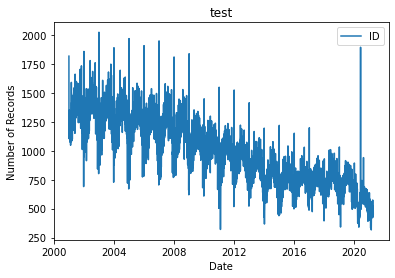

In [27]:
basic_plot(crime_df.groupby('day_date')['ID'].count(), 'Date', 'Number of Records', 'test')

In [29]:
crime_df.groupby('day_date')['ID'].count().sort_values()

day_date
2021-02-15     316
2011-02-02     320
2021-01-31     333
2020-04-19     340
2019-01-30     341
              ... 
2020-05-31    1897
2006-01-01    1911
2007-01-01    1952
2005-01-01    1972
2003-01-01    2027
Name: ID, Length: 7400, dtype: int64

In [30]:
crime_df['Primary Type'].value_counts()

THEFT                                1538717
BATTERY                              1338180
CRIMINAL DAMAGE                       831880
NARCOTICS                             737251
ASSAULT                               464230
OTHER OFFENSE                         453531
BURGLARY                              409236
MOTOR VEHICLE THEFT                   336816
DECEPTIVE PRACTICE                    310360
ROBBERY                               274579
CRIMINAL TRESPASS                     206005
WEAPONS VIOLATION                      88230
PROSTITUTION                           69388
OFFENSE INVOLVING CHILDREN             50976
PUBLIC PEACE VIOLATION                 50891
SEX OFFENSE                            27984
CRIM SEXUAL ASSAULT                    27928
INTERFERENCE WITH PUBLIC OFFICER       17587
GAMBLING                               14595
LIQUOR LAW VIOLATION                   14489
ARSON                                  12283
HOMICIDE                               10981
KIDNAPPING

In [31]:
crime_df['Description'].value_counts()

SIMPLE                                                         858425
$500 AND UNDER                                                 594498
DOMESTIC BATTERY SIMPLE                                        569374
TO VEHICLE                                                     403476
TO PROPERTY                                                    384717
                                                                ...  
UNLAWFUL SALE - OTHER FIREARM                                       1
SPORTS TAMPERING                                                    1
AGG. RITUAL MUTILATION - HANDS, FISTS, FEET, SERIOUS INJURY         1
THEFT RETAIL                                                        1
GAME / AMUSEMENT DEVICE                                             1
Name: Description, Length: 535, dtype: int64

In [94]:
crime_df.loc[:,'latitude_float'] = pd.to_numeric(crime_df.loc[:,'latitude'])
crime_df.loc[:,'longitude_float'] = pd.to_numeric(crime_df.loc[:,'longitude'])

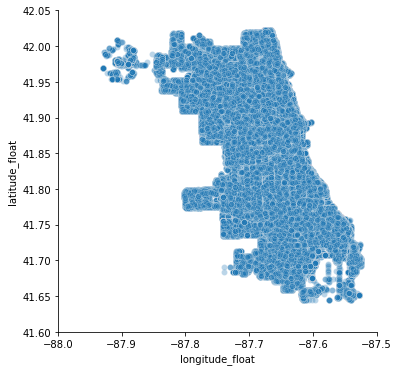

In [110]:
import seaborn as sns
ax = sns.relplot(x='longitude_float', y='latitude_float', data=crime_df, alpha=0.3)
ax.set(ylim=(41.6, 42.05))
ax.set(xlim=(-88, -87.5))